In [3]:
from numpy import linalg as LA 
import scipy.linalg as la
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [4]:
# Conversion parameters for effective mass atomic unit

m2ang = 1 / 1e-10 # Length
def parameter_conversion(effective_mass):
    # conversion parameters for effective mass atomic unit
    eV2eu = np.float64(1/27.211386245988) #/ effective_mass
    ang2eu  = np.float64(1.889725989) #* effective_mass
    amp2eu  = 1/np.float64(6.623618237*1e-3) #/ effective_mass
    return eV2eu, ang2eu, amp2eu

In [5]:
# 1-D tunneling and/or elastic phase-breaking, R vs L, fixed E

def phase_breaking(em, a, D, V, VB, mu, label, color):

    # MKS (eV for energy) -> eu
    effective_mass = em
    eV2eu, ang2eu, amp2eu = parameter_conversion(effective_mass)

    IE     = 1 / (2*np.pi) 
    kT     = 0.025 * eV2eu
    zplus  = 1j* 1e-51 * eV2eu
    
    # Input parameters (eu)
    a  = a * m2ang * ang2eu
    t0 = 1/(2*(a**2)*effective_mass);
    D  = D * eV2eu**2 # Scattering strength 
    V  = V * eV2eu    # Appled voltage
    mu = mu * eV2eu   # Fermi energy
    f1=1/(1+np.exp((-V/2)/kT))  # Fermi function in contant 1 at E = mu
    f2=1/(1+np.exp(( V/2)/kT))  # Fermi function in contant 2 at E = mu
  #  print ("V", V)
    # Actual calculation
    E=mu
    I1 = np.zeros( 22 )
    I2 = np.zeros( 22 )
    L = np.zeros( 22 )

    for k in range(5,27):
        Np=k;#Length of barrier = (Np-2)*a
        UB= np.zeros((k))
        UB[1:Np-1] = VB * eV2eu                        # Potential barrier
        U1= V*np.linspace(0.5, -0.5, Np)               # Applied bias
        T=(2*t0*np.diag(np.ones(Np))) - (t0*np.diag(np.ones(Np-1),1)) - (t0*np.diag(np.ones(Np-1),-1))  # Hamilitonian
        sig1 = np.zeros((Np,Np), dtype=complex)
        sig2 = np.zeros((Np,Np), dtype=complex)
        sig3 = np.zeros((Np,Np), dtype=complex)
        ck = (1-((E + zplus - U1[0]-UB[0])/(2*t0)))
        ka = np.arccos(ck)
        sig1[0,0]= -t0*np.exp(1j*ka)
        gam1 = 1j * ( sig1 -np.matrix(sig1).getH() ) # Self-enegy for contact 1 
        ck = (1-((E + zplus - U1[Np-1]-UB[Np-1])/(2*t0)))
        sig2[Np-1,Np-1]= -t0*np.exp(1j*ka)
        gam2 = 1j * ( sig2 -np.matrix(sig2).getH() ) # Self-enegy for contact 2
        # calculating the Green function, G self-consistently 
        G= inv( ((E+zplus)*np.eye(Np))-T-np.diag(U1+UB)-sig1-sig2 )
        change = 1.0
        while change > 1e-15   : 
            sigp = np.diag( D* np.diag(G) )  # Self-energy due to scattering
            S = inv( ((E + zplus)*np.eye(Np))-T-np.diag(U1+UB)-sig1-sig2-sigp )
            change = np.sum( np.sum(abs(G-S)) ) / ( np.sum( np.sum(abs(G)+abs(S)) ) ) 
            G = (0.5*G) + (0.5*S)
        G = S
        A = 1j * ( G - np.matrix(G).getH() )
        M = D  *  ( G * np.conj(G) )
      #  print (M)
        # calculationg the inscattering function from the contacts F1, F2
        gam1 = 1j * (sig1 - np.matrix(sig1).getH() )
        gam2 = 1j * (sig2 - np.matrix(sig2).getH() )
        gamp = 1j * (sigp - np.matrix(sigp).getH() )
        gamma = gam1 + gam2 + gamp
        sigin1 = f1 * gam1 
        sigin2 = f2 * gam2
        n = np.dot((inv( np.eye(Np)  - M   )) , np.diag(G * (sigin1 + sigin2) * np.matrix(G).getH() ))
        #print (n)
        siginp = D * np.diag(n)
      #  print (siginp)
        # calculating the correlation function Gn
        Gn = G * ( sigin1 + sigin2 + siginp ) * np.matrix(G).getH()
        # calculating the current 

        I1[k-5]=(1/(f1-f2)) * ( np.trace(np.dot(gam1,Gn))-np.trace(np.dot(sigin1,A) )).real
        I2[k-5]=(1/(f1-f2)) * ( np.trace(np.dot(gam2,Gn))-np.trace(np.dot(sigin2,A)) ).real
        L[k-5]=(k-2)*a

    L = L / ang2eu / m2ang / 1e-9     # nm scale

    plt.xlabel("Length (em)")
    plt.ylabel("log10 (resistance)")
    plt.plot(L,np.log10( -1 / I1 ),label = label, color = color)

#### Reproduce Fig. E.11.5
- effective mass (em): 0.25 $m_{e}$
- lattice spacing (a): 3 Å
- applied bias (V): 0.001 eV
- scattering strength (D): 2 eV$^{2}$ & 3 eV$^{2}$
- chemical potential (mu): 0.1 eV

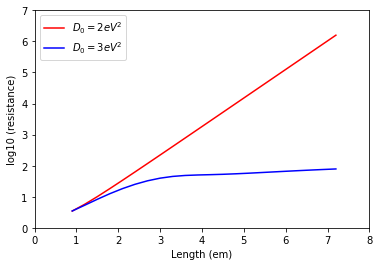

In [4]:
em = 0.25    # effective mass
UB = 0.5     # Potential barrier
a  = 3e-10   # lattice spacing
D1  = 2e-1   # scattering strength
D2  = 3e-1   # scattering strength
V  = 0.001   # applied bias
mu = 0.1     # chemical potential

phase_breaking(em, a, D1, V, UB, mu, label = r'$D_{0}=2eV^{2}$', color = 'r')
phase_breaking(em, a, D2, V, UB, mu, label = r'$D_{0}=3eV^{2}$', color = 'b')
plt.xlim([0,8])
plt.ylim([0,7])
plt.legend()
plt.show()

Phase breaking 이 약한 경우, Transmission은 exponential 하게 decay 하게 됨.  즉, R $\propto$ 1/T 이므로 따라서 R이 logscale 개형을 따름.
반면, Phase breaking이 강한 경우, T$\propto$1/L에 비례하여 R$\propto$L에 선형적으로 증가하게 됨. 즉, log scale에서 saturation 되는 구간 존재.

##### (b) Solve Exercise E.11.5. Try different parameters: lattice points, lattice spacing, effective mass, chemical potential, etc. and discuss the physical and numerical effects.

#### effective mass 변화
- 1 case: 0.1 $m_{e}$
- 2 case: 0.25 $m_{e}$
- 3 case: 0.5 $m_{e}$

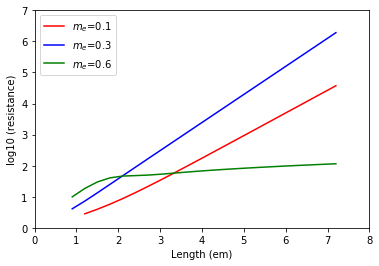

In [428]:
a  = 3e-10   # lattice spacing
D2  = 2e-1   # scattering strength
V  = 0.001   # applied bias
VB = 0.5     # potential barrier
mu = 0.1     # chemical potential

phase_breaking(0.1, a, D2, V, VB, mu, label = r'$m_{e}$=0.1', color = 'r')
phase_breaking(0.3, a, D2, V, VB, mu, label = r'$m_{e}$=0.3', color = 'b')
phase_breaking(0.6, a, D2, V, VB, mu, label = r'$m_{e}$=0.6', color = 'g')

plt.xlim([0,8])
plt.ylim([0,7])
plt.legend()
plt.show()

electron mass가 증가하면, electron의 kinetic energy가 같은 비율만큼 감소하게 된다. 때문에, electron mass 가 증가하면, electron이 potential wall에 localize되게 된다. 때문에 electron mass가 0.1에서 0.3으로 증가하면, 전반적으로 resistance가 증가하게 된다. 여기서 electron mass가 더욱 증가하게 되면, phase breaking으로 인한 electron momentum이 감소하면서 오히려 back scattering이 감소해 long channel legnth에서 resistance가 감소하게 된다. 

#### scattering strenght 변화
- 1 case: 0 $eV^{2}$
- 2 case: 2 $eV^{2}$
- 3 case: 4 $eV^{2}$

V 3.674932217565499e-05
V 3.674932217565499e-05
V 3.674932217565499e-05


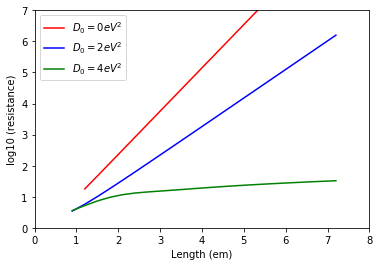

In [424]:
em = 0.25
a  = 3e-10   # lattice spacing
V  = 0.001   # applied bias
VB = 0.5     # potential barrier
mu = 0.1     # chemical potential

phase_breaking(em, a, 0.0, V, VB, mu, label = r'$D_{0}= 0 eV^{2}$', color = 'r')
phase_breaking(em, a, 0.2, V, VB, mu, label = r'$D_{0}= 2 eV^{2}$', color = 'b')
phase_breaking(em, a, 0.4, V, VB, mu, label = r'$D_{0}= 4 eV^{2}$', color = 'g')

plt.xlim([0,8])
plt.ylim([0,7])
plt.legend()
plt.show()

scattering strength 가 커질 수록, resistance가 phase breaking으로 인한 back scattering 감소로 줄어드는 것을 확인 가능.

#### Applied bais 변화
- 1 case: 0.001 eV
- 2 case: 0.005 eV
- 3 case: 0.010 eV

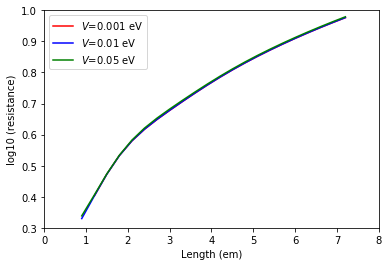

In [437]:
em = 0.25    # effective mass
a  = 3e-10   # lattice spacing
UB = 0.2
D2  = 2e-1   # scattering strength
V  = 0.001   # applied bias
mu = 0.1     # chemical potential

phase_breaking(em, a, D2, 0.001, UB, mu, label = r'$V$=0.001 eV', color ='r')
phase_breaking(em, a, D2, 0.01, UB, mu, label = r'$V$=0.01 eV', color ='b')
phase_breaking(em, a, D2, 0.05, UB, mu, label = r'$V$=0.05 eV', color ='g')

plt.xlim([0,8])
plt.ylim([0.3,1])
plt.legend()
plt.show()

Applied bias 가 증가함에 따라 명확한 resistance의 변화는 관찰 되지 않았다. 이유는 bias 증가에 따른 channel 내부 potential 변화를 self-consistent 하게 계산 하지 않고, linear potential drop 상황을 가정했기 때문이다. 